In [1]:
import cmp
import pdir
from lattices import *
from scattering import *
%matplotlib notebook
np.seterr(invalid='raise')
np.set_printoptions(threshold=np.nan)

In [2]:
# Inputs
eq = np.isclose
# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
blargh = ('r', 'r','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,2,1,1)
verbose = True


# Gridline type:
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# individual: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# sum: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

LatticeType = "conventional fcc"

#Lattice(lattice_name = LatticeType, colors = blargh, sizes = sizes, max_ = Maxs, verbose=True)
#Reciprocal(lattice_name=LatticeType, indices=(1,1,0))

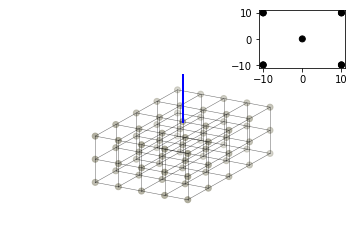

In [3]:
def setup_scattering(lattice_name='simple cubic', k_in=np.array([0,0,-np.pi]), points=None, intensities=None, verbose=False):
    lattice_name = lattice_name.lower()
    min_, max_ = (-2, -2, -1), (2, 2, 1)
    grid_type = latticelines[lattice_name]
    lim_type = "proper"
    colors = ["xkcd:cement",
              "xkcd:cornflower blue",
              "xkcd:cornflower blue",
              "xkcd:cornflower blue"]
    sizes = [1, 1, 1, 1]
    (a1, a2, a3), basis, _ = chooser(lattice_name, verbose=verbose)
    r_min, r_max, n_min, n_max = find_limits(lim_type, a1, a2, a3,
                                                      min_, max_)
    (atomic_positions, lattice_coefficients, atomic_colors, atomic_sizes,
     lattice_position) = generator(a1, a2, a3, basis, colors, sizes,
                                            lim_type, n_min, n_max, r_min,
                                            r_max)
    objects = [atomic_positions, lattice_coefficients, atomic_colors,
               atomic_sizes, lattice_position]
    objects = limiter(atomic_positions, objects, r_min, r_max)
    (atomic_positions, lattice_coefficients, atomic_colors, atomic_sizes,
     lattice_position) = objects
    
    pruned_lines = grid_lines(a1, a2, a3, atomic_positions,
                                       lattice_position, grid_type,
                                       verbose=verbose)
    
    fig = plt.figure()
    ax = fig.gca(projection="3d")

    # Plot atoms. For now a single size and color
    ax.scatter(atomic_positions[:, 0], atomic_positions[:, 1],
               atomic_positions[:, 2], c=atomic_colors, s=atomic_sizes)
    
    g_col = 'k'
    g_w = 0.5
    g_a = 0.6
    
    for line in pruned_lines:
        ax.plot(line[0], line[1], line[2], color=g_col, linewidth=g_w, alpha=g_a)
    
    # Plot the "Beam"
    beam_length = 2
    beam_end_z = 1
    k_disp = beam_length * k_in / lattices.mag(k_in)
    beam = np.array([[-k_disp[0], 0], [-k_disp[1], 0], [-k_disp[2] + beam_end_z, beam_end_z]])
    ax.plot(beam[0], beam[1], beam[2], linewidth=2, color='b')
    
    ax.set_aspect('equal')
    ax.set_proj_type('ortho')
    ax.set_xlim([r_min[0], r_max[0]])
    ax.set_ylim([r_min[1], r_max[1]])
    ax.set_zlim([r_min[2], r_max[2]])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.grid(False)
    plt.axis('off')
    plt.axis('equal')
    
    a = plt.axes([0.7, 0.7, 0.2, 0.2])
    if points is not None and intensities is not None:
        # Normalize intensities
        intensities /= np.amax(intensities)
        # Create the color array
        colors = np.zeros((intensities.size,4))
        colors[:,3] = intensities
        plt.scatter(points[:,0], points[:,1], c = colors)

def prune_scattered_points(points, intensities, indices):
    """
    We prune the array of points, so we're left with unique points. The intensities are adjusted accordingly, and the indices are made into a list of strings, with one element per unique point
    """
    unique_points, ids, inverse = np.unique(points, axis=0, return_index=True, return_inverse=True)
    new_intensities = np.zeros(ids.shape)
    new_indices = [None] * new_intensities.size
    for i in range(intensities.size):
        new_id = inverse[i]
        index = tuple(indices[i])
        new_intensities[new_id] += intensities[i]
        if new_indices[new_id] is None:
            new_indices[new_id] = "{}".format(index)
        else:
            new_indices[new_id] = "{}\n{}".format(new_indices[new_id], index)
            
    return unique_points, new_intensities, new_indices

(a1, a2, a3), basis, _ = chooser(lattice_name='simple cubic')
scattering_length = [1]
k_in = np.array([0,0, -3*np.pi])
intensities, k, indices = scattering(a1, a2, a3, basis, scattering_length, k_in)
points = projection(k)
setup_scattering(points=points, intensities=intensities, k_in = k_in)